# Lab 3: Mapping with Fully-Connected Networks
Blocks of dense layers are really good at memorizing patterns.
This week we'll step outside the traditional "prediction" regime of machine learning and use a fully-connected network (FCN) to represent a 2-D scene in its weight by interpolating between known points.

Throughout, you should be impressed by two (related) properties of dense neural nets:
 - They have high enough capacity to entirely memorize complex patterns
 - They are sufficiently nonlinear to build these patterns up from simple inputs (like (x, y) coordinates in this case)

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Pointcloud mapping

![full scene](./images/full_scene.png)

### The problem
Imagine there is a square (2-D) room with four walls and several square and circular objects in it.
We put laser distance sensors around the room, which shoot rays that continue until they hit an object or a wall and report the distance, with limited angular and radial resolution.
We want to use this limited data to produce a full 2-D reconstruction of the scene, filling in points the sensors haven't observed with likely values (in essence, interpolating).

### The data
We know that every ray that there's an object at the point each ray hit, and we also know that there's no object between the camera and the contact point.
The data is provided as (x, y) pairs, where some points correspond to places we know are on object boundaries (shown in green above) and points we know are not inside objects (shown in red above).

These points come in two data files: `data/positives.txt` for points on the edge of objects, and `data/negatives.txt` for points outside of objects.
To generate these files, run `make_data.py`.

(Check out the code if you want to see how the points are generated, but don't change anything!)

### The model
We want to store a full description of the scene in the weights of a neural network.
To do this, we'll train a FCN to classify (x, y) points by whether or not they are the edge of a wall or object.
Then, we can draw the scene by sampling (x, y) pairs and drawing the model's output.
So, the network has "memorized" where the objects and walls are, and what their shapes are.

# Section 1: Load the data
Load the data using `np.loadtxt()` (default arguments should work), then convert it to a usable format with a feature array and label array, which is 1 if a point is the edge of an object and 0 if it is not.

Functions to look at:
 - `np.loadtxt`
 - `np.concatenate`

In [2]:
# Your code here
pos_data = np.loadtxt('./data/positives.txt')
pos_label = np.ones([pos_data.shape[0],1])
pos_data_full = np.concatenate((pos_data,pos_label),axis=1)
neg_data = np.loadtxt('./data/negatives.txt')
neg_label = np.zeros([neg_data.shape[0],1])
neg_data_full = np.concatenate((neg_data,neg_label),axis=1)
print(pos_data_full.shape)
print(neg_data_full.shape)

together = np.concatenate((pos_data_full,neg_data_full))
np.random.shuffle(together)
print(together.shape)
x_all = together[:, :-1]
y_all = together[:, -1]
print(x_all)
print(y_all)

(838, 3)
(27718, 3)
(28556, 3)
[[ 0.66510214  0.14954305]
 [-0.24156918 -0.37723047]
 [ 0.04821547  0.38497344]
 ...
 [ 0.79019996  0.95799667]
 [ 0.65148506  0.01102537]
 [ 0.77026553  0.54838387]]
[0. 0. 0. ... 0. 0. 0.]


In [3]:
sum(y_all)

838.0

# Section 2: Build a data pipeline
Set up a `tf.data.Dataset` and a `tf.data.Iterator`.
This time, there's no test set, just a single dataset.

In [4]:
# Your code here
n_epochs = 100
batch_size = 32
dataset_train = tf.data.Dataset.from_tensor_slices((x_all, y_all))\
    .shuffle(500).batch(batch_size).cache()

In [5]:
iterator = tf.data.Iterator.from_structure(
    dataset_train.output_types, 
    dataset_train.output_shapes)
train_init_op = iterator.make_initializer(dataset_train)

Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(iterator)`.
Instructions for updating:
Use `tf.compat.v1.data.get_output_classes(iterator)`.


# Section 3: Build a model graph
The model is a simple fully-connected neural network with four hidden layers, each with 64 units, and an output layer that performs binary classification with sigmoid activation.
Recall that the input is just a pair (x, y).

Functions to look at throughout:
 - `tf.cast`
 - `tf.expand_dims`
 - `tf.squeeze`
 - arithmetic operations

### 3.1: Input tensors
Get a tensor for the input coordinates and for the correct label.

In [6]:
# Your code here
# Input tensors
with tf.name_scope('inputs'):
    next_elem = iterator.get_next()
    features, target = next_elem
print(target.shape)

(?,)


In [7]:
n_points = x_all.shape[0]
n_features = x_all.shape[1]
n_train = n_points # only training set

### 3.2: Helper function to make dense layers
It's tedious (and bad design) to explicitly write out every variable, matrix multiplication, etc.
Instead, it's common to define helper functions that create one of a structure you expect to repeat in your model.

Write a function called `make_dense_layer(...)`, which has its signature and scopes defined as a stub below.
When called, it should add variables and operations to the graph which implement a single dense layer.

If `do_activation` is True, it should apply ReLU activation to the computed values.
To do this, you can use `tf.nn.relu`.

In [8]:
def make_dense_layer(prev_activations, dim_input, dim_output, 
                     do_activation=True, postfix=''):
    '''
    Adds a dense layer to the model graph.
    
    Parameters
    ----------
    prev_activations: tensor
        The activations of the previous layer, or 
        the input for the first dense layer.
    dim_input: int
        Number of features in the input representation.
    dim_output: int
        Number of features in the output representation.
        Equivalently, number of units in this layer.
    do_activation: bool
        Whether or not to apply ReLU activation.
    postfix: string
        Postfix on name and variable scopes in this layer.
        Used to simplify visualizations.
        
    Returns
    -------
    A tensor representing the activations of this layer.
    '''
    print(prev_activations.shape)
    with tf.name_scope('dense' + postfix):
        with tf.variable_scope('dense' + postfix): #postfix
            # Define variables here
            weights = tf.get_variable('weights'+ postfix, shape=(dim_input,dim_output), dtype=tf.float64,
                                      initializer=tf.glorot_uniform_initializer())
            bias = tf.get_variable('bias'+ postfix, shape=(1,dim_output), dtype=tf.float64,
                                   initializer=tf.zeros_initializer())
        # Define operations here
        output1 = tf.cast(tf.matmul(prev_activations,weights) + bias,tf.float64)
        if do_activation:
            output2 = tf.cast(tf.nn.relu(output1),tf.float64)
        else:
            output2 = output1
        return output2

### 3.3: Make dense layers
Use the helper function to make four dense layers.
Each should have 64 units, the correct input dimensions, and a distinct (and meaningful) postfix.

In [9]:
# Your code here
hidden_layer_1 = make_dense_layer(features,2,64,do_activation=True,postfix='h1')
hidden_layer_2 = make_dense_layer(hidden_layer_1,64,64,do_activation=True,postfix='h2')
hidden_layer_3 = make_dense_layer(hidden_layer_2,64,64,do_activation=True,postfix='h3')
hidden_layer_4 = make_dense_layer(hidden_layer_3,64,64,do_activation=True,postfix='h4')

(?, 2)
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 64)
(?, 64)
(?, 64)


### 3.4: Compute logit
Use the helper function to make a final dense layer with `dim_output=1` to compute the final logit.

In [10]:
# Your code here
logits = make_dense_layer(hidden_layer_4,64,1,do_activation=False,postfix='logits') #logits
logits.shape

(?, 64)


TensorShape([Dimension(None), Dimension(1)])

### 3.5: Compute class probability for output
Use `tf.sigmoid` to compute the probability that the input coordinate is a boundary point.
We will not use this for the loss, just for the output.

In [11]:
# Your code here
output = tf.sigmoid(logits)
output.shape

TensorShape([Dimension(None), Dimension(1)])

### 3.6: Compute weighted cross-entropy loss
There are about 33 times as many non-boundary coordinates as there are boundary coordinates.
To prevent the network from just learning to predict that every coordinate is not a boundary, we should weight the loss function to consider boundary pixels more heavily.

To do this, use `tf.nn.weighted_cross_entropy_with_logits()` on the logits computed before, plus the input label, and a positive weight of 20.
Then, produce the mean loss for the batch with `tf.reduce_mean`, and add a summary scalar to plot loss in TensorBoard.

In [12]:
# Your code here
weighted_cross_entropy = tf.nn.weighted_cross_entropy_with_logits(target,tf.squeeze(logits,axis=1),20)

loss = tf.reduce_mean(weighted_cross_entropy)
    
tf.summary.scalar('loss', loss)

<tf.Tensor 'loss:0' shape=() dtype=string>

In [13]:
print(target.shape)

(?,)


### 3.7: Optimizer and gradients
Make an optimizer (I used `tf.train.MomentumOptimizer` with `lr=1e-3` and `momentum=0.9`).
Then, explicitly compute the gradients in a variable called `gradients` (so we can plot them below) and make an operation that applies those gradients to the graph.

Note: don't use `optimizer.minimize`, which will result in computing the gradients twice since we already have them from `compute_gradients`.

In [14]:
# Your code here
optimizer = tf.train.MomentumOptimizer(1e-3,0.9)
gradients = optimizer.compute_gradients(loss)
apply_grad = optimizer.apply_gradients(gradients)

### 3.8: Plot variables and gradients
You don't need to do this for every model, but it's illustrative to do at least once.
I've written the code for this below, with a pattern borrowed from http://matpalm.com/blog/viz_gradient_norms/.

In [15]:
with tf.name_scope('visualization'):
    for gradient, variable in gradients:
        if variable.name and gradient is not None:
            tf.summary.histogram('gradients/' + variable.name, tf.norm(gradient))
            tf.summary.histogram('variables/' + variable.name, tf.norm(variable))

INFO:tensorflow:Summary name gradients/denseh1/weightsh1:0 is illegal; using gradients/denseh1/weightsh1_0 instead.
INFO:tensorflow:Summary name variables/denseh1/weightsh1:0 is illegal; using variables/denseh1/weightsh1_0 instead.
INFO:tensorflow:Summary name gradients/denseh1/biash1:0 is illegal; using gradients/denseh1/biash1_0 instead.
INFO:tensorflow:Summary name variables/denseh1/biash1:0 is illegal; using variables/denseh1/biash1_0 instead.
INFO:tensorflow:Summary name gradients/denseh2/weightsh2:0 is illegal; using gradients/denseh2/weightsh2_0 instead.
INFO:tensorflow:Summary name variables/denseh2/weightsh2:0 is illegal; using variables/denseh2/weightsh2_0 instead.
INFO:tensorflow:Summary name gradients/denseh2/biash2:0 is illegal; using gradients/denseh2/biash2_0 instead.
INFO:tensorflow:Summary name variables/denseh2/biash2:0 is illegal; using variables/denseh2/biash2_0 instead.
INFO:tensorflow:Summary name gradients/denseh3/weightsh3:0 is illegal; using gradients/denseh3/w

# Section 4: train the model
Same as last time, except there's no test set.
You don't need to distinguish between epochs and steps here, but do run the summary ops and log the summaries.

I used 50 epochs, and got a final cross-entropy loss of about 0.3.
You might not need to use this many epochs to get reasonable results, but more will get crisper results.

This might take a while on CPUs, so if it's taking too long, think about:
 - Using Google Colaboratory
 - Increasing your batch size
 - Reducing the frequency with which you run summary ops, save metadata, etc
 
Watching plots, histograms, etc in TensorBoard as the model trains can be fun.

In [16]:
# Your code here
# Training code
saver = tf.train.Saver() # Save varibles
merged_summaries = tf.summary.merge_all() # Single merged summary op
train_batch = 0
with tf.Session() as sess:
    # Make one writer for training logs and another for test logs 
    train_writer = tf.summary.FileWriter('./logs_lab/train', graph=sess.graph)
    # Initialize all variables
    sess.run(tf.global_variables_initializer())
    
    # Training loop
    for epoch in range(n_epochs):
        # Load training data
        sess.run(train_init_op)
        l=[]
        # Iterate over the dataset once
        while True:
            try:
                if train_batch > 0: # Typical batch
                    # Run summary ops and optimization
                    summary, l1,_ = sess.run([merged_summaries,loss,apply_grad])
                    l.append(l1)
                    train_writer.add_summary(summary, train_batch)
                    train_batch += 1
                else:
                    # On the first batch, run a full trace
                    run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
                    run_metadata = tf.RunMetadata()
                    
                    summary,l1 = sess.run([merged_summaries,apply_grad],
                                          options=run_options,
                                          run_metadata=run_metadata)
                    
                    train_writer.add_summary(summary, train_batch)    
                    train_writer.add_run_metadata(run_metadata, 
                                                  'first training batch')
                    train_batch += 1
            except tf.errors.OutOfRangeError: # No more data
                break
    
        
        print('Epoch:', epoch)
        print(sum(l)/len(l))
        
        
    # Save model
    saver.save(sess, './checkpoints_lab/model.ckpt')

Epoch: 0
1.0299883485535652
Epoch: 1
0.9999508079461127
Epoch: 2
0.9618011164157259
Epoch: 3
0.9333982132846267
Epoch: 4
0.9177765208662081
Epoch: 5
0.9012851362194052
Epoch: 6
0.8911748143519937
Epoch: 7
0.8739507590532157
Epoch: 8
0.8624462837373356
Epoch: 9
0.8406591279637547
Epoch: 10
0.8192826607627536
Epoch: 11
0.7978634695627133
Epoch: 12
0.7764150110069784
Epoch: 13
0.7428164347584465
Epoch: 14
0.7222498719205208
Epoch: 15
0.7010264854800914
Epoch: 16
0.6922767226073203
Epoch: 17
0.6632532235386317
Epoch: 18
0.6299421509061636
Epoch: 19
0.6208222871659007
Epoch: 20
0.6196985818180076
Epoch: 21
0.5870550958731293
Epoch: 22
0.5790708249428799
Epoch: 23
0.5998487745773011
Epoch: 24
0.5387463888453273
Epoch: 25
0.5376317164047865
Epoch: 26
0.5515505263454684
Epoch: 27
0.5313859832503124
Epoch: 28
0.5197564164159331
Epoch: 29
0.5285689944677101
Epoch: 30
0.5079881582812349
Epoch: 31
0.5095708359388451
Epoch: 32
0.5101473487050336
Epoch: 33
0.49179016637095596
Epoch: 34
0.50257013048

# Section 5: Plot the model
Let's see what the network learned.
Generate 100 x values and 100 y values, each in the range (-1, 1).
Then compute the value of `probability` using every coordinate in that grid (every pairwise combination of x and y values), and plot a "map" of those probabilities using `plt.scatter()` (check out the `c` argument).

You can use `feed_dict` to pass in data, since efficiency matters less here than in training.
I used it to overwrite the input coordinates, since I didn't define a `Dataset` here.
But, there are multiple ways to do this (e.g. defining a new `Dataset` of coordinates and fake labels).

Remember to load the trained weights before running inference.

INFO:tensorflow:Restoring parameters from ./checkpoints_lab/model.ckpt


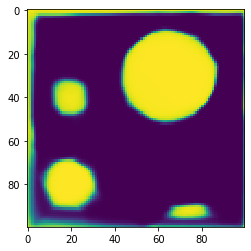

In [37]:
# Your code here
with tf.Session() as sess:
    saver.restore(sess, './checkpoints_lab/model.ckpt')
    
    x_set = []
    y_set = []
    probs = np.zeros([100,100])
    for i in range(100):
        for j in range(100):
            probability = sess.run(output,feed_dict={features:[[0.02*i-1,0.02*j-1]]})
            probs[i,j] = probability
            if probability > 0.5:
                x_set.append(0.02*i-1)
                y_set.append(0.02*j-1)
    #plt.scatter(x_set,y_set)
    plt.imshow(probs)
    
    #print(sess.run([pred_label,tf.argmax(target,axis=1)])) 



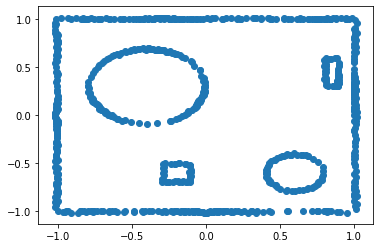

In [35]:
plt.scatter(pos_data[:,0],pos_data[:,1])
# note that the figure below is just a 90-degree rotation of the figure above.

# Section 6: TensorBoard plots
This time, we have some more interesting TensorBoard plots than last time.
Run TensorBoard, and look at:
 - The model graph in Graphs
 - The loss over time in Scalars
 - The weights, biases, and gradients over time in Distributions and Histograms
 
The loss should decrease over time, and eventually stabilize (with some noise).

The gradients for weights and biases may not go to zero, and your weights and biases may not look like they're converging.
This is because of "bias drift" where multiple possible settings of weights and biases have the same loss value.
To fix this, we could add a term to the loss which penalizes the model slightly based on the magnitude of the bias terms.

# Section 7: Again, but in Keras
Make a Keras Sequential model which is equivalent to the one we've trained in TensorFlow.
Train it on the same dataset, and again plot its output in the same way. 

Hints:
 - This won't take nearly as long as the previous sections
 - You don't need to use `keras.utils.to_categorical` since this is binary classification.
 - The appropriate loss function is 'binary_crossentropy'
 - To implement the same loss weighting, use `class_weight={0: 1.0, 1:20.0}` in `model.fit()`
 - You can get the outputs of the model over the entire grid at once with `model.predict()`

### 7.1: Build a model
Use `keras.models.Sequential` to build the same FCN as before.

In [46]:
# Your code here
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

# Create an "empty" model
model = Sequential()

model.add( Dense(64, input_shape=(2,)) )
model.add(Activation('relu'))

model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

### 7.2: Define an optimizer and compile the model

In [47]:
# Your code here
from keras.optimizers import SGD

optimizer = SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['binary_accuracy',
                       'binary_crossentropy'])

### 7.3: Fit the model

In [50]:
# Your code here

model.fit(x_all, y_all,
          epochs=100, batch_size=32,
          class_weight={0: 1.0, 1:20.0})

Epoch 1/100
28556/28556 [==============================] - 2s 54us/step - loss: 1.0330 - binary_accuracy: 0.9669 - binary_crossentropy: 0.5230
Epoch 2/100
28556/28556 [==============================] - 1s 38us/step - loss: 1.0080 - binary_accuracy: 0.9698 - binary_crossentropy: 0.4899
Epoch 3/100
28556/28556 [==============================] - 1s 37us/step - loss: 0.9717 - binary_accuracy: 0.9115 - binary_crossentropy: 0.4720
Epoch 4/100
28556/28556 [==============================] - 1s 44us/step - loss: 0.9429 - binary_accuracy: 0.8327 - binary_crossentropy: 0.4659
Epoch 5/100
28556/28556 [==============================] - 1s 45us/step - loss: 0.9260 - binary_accuracy: 0.8252 - binary_crossentropy: 0.4517
Epoch 6/100
28556/28556 [==============================] - 1s 47us/step - loss: 0.9078 - binary_accuracy: 0.8112 - binary_crossentropy: 0.4470
Epoch 7/100
28556/28556 [==============================] - 1s 45us/step - loss: 0.8964 - binary_accuracy: 0.8047 - binary_crossentropy: 0.4404

28556/28556 [==============================] - 1s 34us/step - loss: 0.3476 - binary_accuracy: 0.8974 - binary_crossentropy: 0.2077
Epoch 58/100
28556/28556 [==============================] - 1s 35us/step - loss: 0.3627 - binary_accuracy: 0.8983 - binary_crossentropy: 0.2140
Epoch 59/100
28556/28556 [==============================] - 1s 34us/step - loss: 0.4259 - binary_accuracy: 0.8847 - binary_crossentropy: 0.2401
Epoch 60/100
28556/28556 [==============================] - 1s 34us/step - loss: 0.3594 - binary_accuracy: 0.8960 - binary_crossentropy: 0.2126
Epoch 61/100
28556/28556 [==============================] - 1s 34us/step - loss: 0.3563 - binary_accuracy: 0.8967 - binary_crossentropy: 0.2148
Epoch 62/100
28556/28556 [==============================] - 1s 35us/step - loss: 0.3281 - binary_accuracy: 0.9045 - binary_crossentropy: 0.1969
Epoch 63/100
28556/28556 [==============================] - 1s 36us/step - loss: 0.3453 - binary_accuracy: 0.9015 - binary_crossentropy: 0.2076
Epoch

### 7.4: Plot the model

In [72]:
# Your code here
pred = model.predict(np.array([[0.66510214, 0.14954305]]))

In [76]:
np.squeeze(pred).shape

()

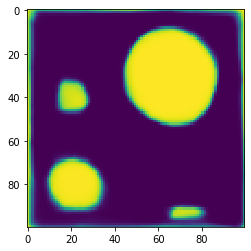

In [77]:
x_set_keras = []
y_set_keras = []
probs_keras = np.zeros([100,100])
for i in range(100):
    for j in range(100):
        pred = model.predict(np.array([[0.02*i-1,0.02*j-1]]))
        probs[i,j] = np.squeeze(pred)
        if probability > 0.5:
            x_set_keras.append(0.02*i-1)
            y_set_keras.append(0.02*j-1)
#plt.scatter(x_set,y_set)
plt.imshow(probs)